In [1]:
from graphviz import Source
from IPython.display import Image
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/Shareddrives/Data/밑바닥부터 시작하는 딥러닝

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/Data/밑바닥부터 시작하는 딥러닝


# Step 59 - RNN

In [2]:
import numpy as np
import dezero.layers as L

rnn = L.RNN(10) # 은닉층의 크기만 지정
x = np.random.rand(1, 1)
h = rnn(x)
print(h.shape)
y = rnn(np.random.rand(1, 1))
print(y.shape)

(1, 10)
(1, 10)


In [3]:
from dezero import Model
import dezero.functions as F
import dezero.layers as L

class SimpleRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.RNN(hidden_size)
        self.fc = L.Linear(out_size)

    def reset_state(self):
        self.rnn.reset_state()

    def forward(self, x):
        h = self.rnn(x)
        y = self.fc(h)
        return y

In [4]:
seq_data = [np.random.randn(1, 1) for _ in  range(10000)]   # 더미 시계열 데이터
xs = seq_data[0:-1]
ts = seq_data[1:]   # 정답 데이터 : xs보다 한 단계 앞선 데이터

model = SimpleRNN(10, 1)

loss, cnt = 0, 0

for x, t in zip(xs, ts):
    y = model(x)
    loss += F.mean_squared_error(y, t)

    cnt += 1

    if cnt == 2:
        model.cleargrads()
        loss.backward()
        break

predict Sin wave

999
(array([0.02624261]), array([0.02492104]))
(array([0.02492104]), array([-0.00669001]))
(array([-0.00669001]), array([0.05171543]))


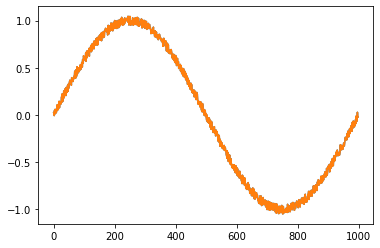

In [5]:
import numpy as np
import dezero.datasets as dsets
import matplotlib.pyplot as plt

train_set = dsets.SinCurve(train=True)
print(len(train_set))
print(train_set[0])
print(train_set[1])
print(train_set[2])


# 그래프 그리기
xs = [example[0] for example in train_set]
ts = [example[0] for example in train_set]
plt.plot(np.arange(len(xs)), xs, label='xs')
plt.plot(np.arange(len(ts)), ts, label='ts')
plt.show()

In [6]:
import dezero


max_epoch = 100
hidden_size = 100
bptt_length = 30    # BPTT 길이
seqlen = len(train_set)

model = SimpleRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

# train
for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0

    for x, t in train_set:
        x = x.reshape(1, 1)
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1

        # Truncated BPTT의 타이밍 조정
        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()
            loss.backward()
            loss.unchain_backward() # 연결 끊기
            optimizer.update()

    avg_loss = float(loss.data) / count
    print(f'| epoch {epoch+1} | loss {avg_loss}')

| epoch 1 | loss 0.12805898389302742
| epoch 2 | loss 0.13580451358633908
| epoch 3 | loss 0.021200884466461452
| epoch 4 | loss 0.005499103440523778
| epoch 5 | loss 0.0027512957206029367
| epoch 6 | loss 0.0021952474721775614
| epoch 7 | loss 0.0020664311628782366
| epoch 8 | loss 0.0021079319643182537
| epoch 9 | loss 0.002030638975390474
| epoch 10 | loss 0.002382465270860591
| epoch 11 | loss 0.0031368060715637547
| epoch 12 | loss 0.004993254641404902
| epoch 13 | loss 0.007658103157788917
| epoch 14 | loss 0.007621525859411228
| epoch 15 | loss 0.0047336637915421816
| epoch 16 | loss 0.0033972172521423184
| epoch 17 | loss 0.0036785715140934807
| epoch 18 | loss 0.004939244236710137
| epoch 19 | loss 0.006792312912569574
| epoch 20 | loss 0.007549148526650996
| epoch 21 | loss 0.00602026290509257
| epoch 22 | loss 0.004288734388246705
| epoch 23 | loss 0.003807718684795029
| epoch 24 | loss 0.00420605770778194
| epoch 25 | loss 0.005098062376468177
| epoch 26 | loss 0.0059619096

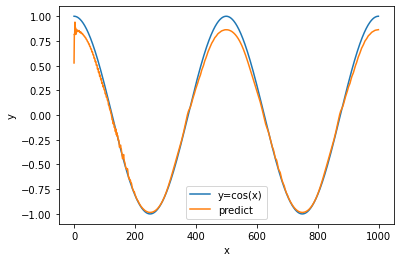

In [7]:
xs = np.cos(np.linspace(0, 4*np.pi, 1000))
model.reset_state() # 모델 재설정
pred_list = []

with dezero.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()